## CLI/Functional analysis of patch clamp data

The pyAPisolation package has several entry points for analysis. While most of the package is currently built for use with ABF, I have been making progress in making functions that accept and process various data types.

*** Note: For install instructions please see the main readme ***

### Data Set-up

Majority of the analysis functions should now accept data in the form of a numpy array (at a minimum). For higher level functions this data should be in the form of `[Sweeps, Time points]`. In this case, `Sweeps` refers to each set of episodic stimulation applied to a cell. For each cell, you will need three arrays:  
- x : The time array (in seconds)
- y : The voltage response array (in mV)
- c : The applied stimuli (in pA)

Each array will need to have equal size. Below we load one of our abf files into numpy arrays for further analysis. However, these arrays could be sourced from anywhere.

==== Data Shapes ===
x shape: (15, 250000), y shape: (15, 250000), c shape: (15, 250000)


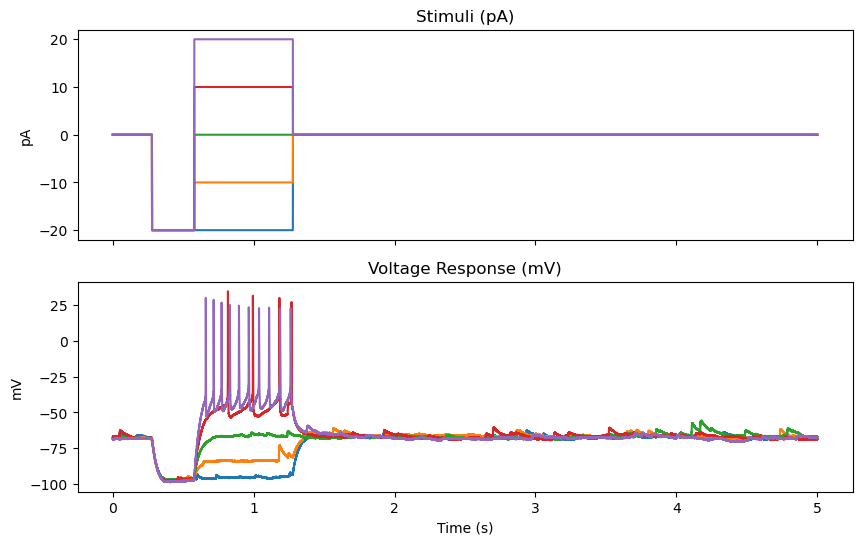

In [3]:
import pyAPisolation.loadFile as lf
import numpy as np
import matplotlib.pyplot as plt

data_path = './data/demo_data_2.abf'

x,y,c = lf.loadABF(data_path)
print("==== Data Shapes ===")
print(f"x shape: {x.shape}, y shape: {y.shape}, c shape: {c.shape}") #should be 15 sweeps

fig, ax = plt.subplots(2,1, figsize=(10,6), sharex=True)
ax[0].set_title('Stimuli (pA)')
ax[0].set_ylabel('pA')

ax[1].set_title('Voltage Response (mV)')
ax[1].set_ylabel('mV')
ax[1].set_xlabel('Time (s)')
for i in range(5):
    ax[1].plot(x[i,:], y[i,:])
    ax[0].plot(x[i,:], c[i,:])

### Spike Feature analysis

The majority of the code for extracting spiking features is in `pyAPisolation.featureExtractor`. In this case, the functions to take note of are `analyze` and `batch_feature_extract`. These handle a variety inputs and output dataframes with all features used in Sunstrum et. al. 202X.    
Lets take a look at the call signature for analyze:

```python
#=== functional interface for programmatic use ===
def analyze(x=None, y=None, c=None, file=None, param_dict=DEFAULT_DICT, return_summary_frames=False):
    """ Runs the ipfx feature extractor over a single sweep, set of sweeps, or file. Returns the standard ipfx dataframe, and summary dataframes (if requested).
    Args:
        x (np.array, optional): The time array of the sweeps. Defaults to None.
        y (np.array, optional): The voltage array of the sweeps. Defaults to None.
        c (np.array, optional): The current array of the sweeps. Defaults to None.
        file (str, optional): The file path. Defaults to None.
        param_dict (dict, optional): The dictionary of parameters that will be passed to the feature extractor. Defaults to None.
        return_summary_frames (bool, optional): If True, will return the summary dataframes. Defaults to False.
    Returns:
        df_spike_count (pd.DataFrame): The dataframe that contains the standard ipfx features for the sweep, oriented sweepwise
        (optional) df_raw_out: A dataframe of the full data as returned by the ipfx feature extractor. Consists of all the sweeps in the files stacked on top of each other.
        (optional) df_running_avg_count (pd.DataFrame): The dataframe that contains the standard ipfx features for the consecutive spikes in the sweep
    """
```
In this case, we simply need to pass in either a filepath or the (x,y,c) arrays. 
We also want to pass in the `param_dict`, this defines the analysis settings. Majority of these are thresholds for action potential detection, we have defined a set of parameters that work for the inoue lab in the DEFAULT_DICT. These will depend on your sampling rate, cell population, and personal judgment as to what makes a action potential.
The parameter dict contains the following options:
```python
DEFAULT_DICT = {'filter': 0, # lowpass filter frequency in Hz (for the allen inst. filter)
                'dv_cutoff': 7.0, # min dV/dt to consider a spike (mV/ms)
                'start': 0.0, # time to start looking for spikes (s)
                'end': 0.0, # time to stop looking for spikes (s), if 0 will be set to end of sweep
                'max_interval': 0.005, # max interval between spike peaks (s)
                'min_height': 2.0, # min height of spike (mV)
                'min_peak': -10.0, # min voltage at spike peak (mV)
                'stim_find': True, # if True will try to find the stimulation time from the current trace
                'thresh_frac': 0.2, # fraction of spike height to use for threshold (0.0-1.0)
                'bessel_filter': -1, # cutoff frequency of bessel filter, if -1 no filter will be applied
                }
```

This returns 3 dataframes:
df_raw_out : This is a dataframe that returns all features for all spikes across all sweeps stacked into rows. This will be in the shape `[# spikes, spike features]`.  
df_spike_count : This is a dataframe that contains the summary features per cell. This dataframe features one row per cell. This is the most common output we use at the inoue lab. It includes things like spike count per sweep, mean threshold, mean upstroke. This is output in the form of `[# cells, features]` 
df_running_avg_count: This is a dataframe that contains the running average across several sweeps for several features. 

In [5]:
import pyAPisolation.featureExtractor as fe

df_spike_count, df_raw_out, df_running_avg = fe.analyze(x=x, y=y, c=c, param_dict=fe.DEFAULT_DICT, return_summary_frames=True)
#print(" === df_raw_out === ")
#print(df_raw_out.head().to_markdown())
print(" === df_spike_count === ")
print(df_spike_count.head().iloc[:,:10].to_markdown())
#print(" === df_running_avg === ")
#print(df_running_avg.head().to_markdown())

INFO:pyAPisolation.patch_utils:User passed in ndarray
INFO:pyAPisolation.dataset:Creating cellData object
INFO:pyAPisolation.dataset:Loading data from arrays
INFO:pyAPisolation.dataset:Generating name from data


Stimulation time found: 0.27812000000000003 to 1.2781
Processed Sweep 001 with 0 aps
Processed Sweep 002 with 0 aps
Processed Sweep 003 with 0 aps
Processed Sweep 004 with 4 aps
Processed Sweep 005 with 10 aps
Processed Sweep 006 with 14 aps
Processed Sweep 007 with 18 aps
Processed Sweep 008 with 20 aps
Processed Sweep 009 with 25 aps
Processed Sweep 010 with 27 aps
Processed Sweep 011 with 34 aps
Processed Sweep 012 with 30 aps
Processed Sweep 013 with 15 aps
Processed Sweep 014 with 15 aps
Processed Sweep 015 with 11 aps
 === df_spike_count === 
|    | filename                   | foldername   |   Sweep 001 spike count |   first_isi_3_spikes001 |   latency_3_spikes001 |   last_isi001 isi |   min_isi001 isi |   adapt001 |   isi_cv001 |   mean_isi001 |
|---:|:---------------------------|:-------------|------------------------:|------------------------:|----------------------:|------------------:|-----------------:|-----------:|------------:|--------------:|
|  0 | unamed_1853117099377

using these data frames we can now get things like exact spike times etc. 

(0.0, 2.0)

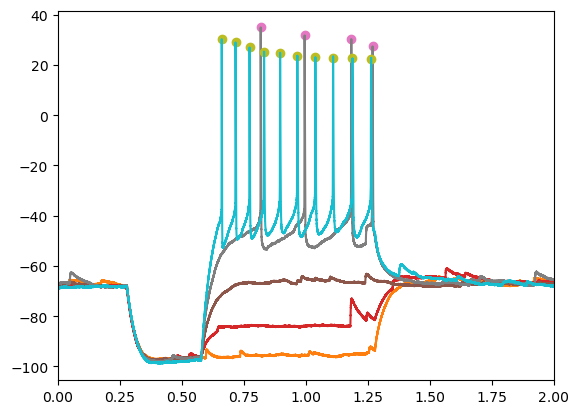

In [3]:

for i in range(5):
    plt.plot(df_raw_out['peak_t'][df_raw_out['sweep Number']==(i+1)], df_raw_out['peak_v'][df_raw_out['sweep Number']==(i+1)], 'o')
    plt.plot(x[i,:], y[i,:])
plt.xlim(0,2)
    

### Subthreshold Analysis

The subthreshold analysis is a bit more rough. Currently it has been back adapted to support usage of numpy arrays. In this case, the main function to use is `analyze_subthreshold`. Here is the call signature:
```python
def analyze_subthres(x=None, y=None, c=None, file=None, protocol_name='', savfilter=0, start_sear=None, end_sear=None, subt_sweeps=None, time_after=50, bplot=False):
    """ This function will compute the subthreshold features for a given sweep or set of sweeps. It will return a dataframe of the features, as well as an average dataframe.
    takes:
        x (np.array): The time array of the cell (1d or 2d array)
        y (np.array): The voltage array of the cell (1d or 2d  array)
        c (np.array): The current array of the cell (1d or 2d  array)
        file (str): The file path of the cell
        protocol_name (str): The name of the protocol to filter by. Defaults to '' - no filtering.
        savfilter (int): The window size of the savgol filter to apply to the data. Defaults to 0 - no filter.
        start_sear (float): The start time to search for the subthreshold features. Defaults to None - start of sweep.
        end_sear (float): The end time to search for the subthreshold features. Defaults to None - end of sweep.
        subt_sweeps (list): The list of sweeps to analyze. Defaults to None - all sweeps.
        time_after (float): The time after the initiation of the subthreshold pulse to fit the curves to. In pct.(%)
        bplot (bool): If True, will plot the subthreshold features. Defaults to False.
    returns:
        df (pd.DataFrame): The dataframe that contains the subthreshold features for the sweep
        avg (pd.DataFrame): The dataframe that contains the average subthreshold features for the sweep
    """
```
Here, you pass in your numpy arrays (or file) similar to above. In this case, you will pass in your search parameters as simple keyword args. Due to lack of foresight - I did not use the same keywords between the spike analysis, and subthreshold analysis. I will fix this in a later version, but for legacy reasons I am leaving it as is for now.
This function attempts to automatically detect the subthreshold components. In this case, it takes the first hyperpolarizing pulse for analysis. I reccommend setting start_sear - if you have a test pulse or something you want to skip.

In [ ]:
subthres_df, subthres_avg = fe.analyze_subthres(x=x, y=y, c=c, savfilter=0, start_sear=None, end_sear=None, subt_sweeps=None, time_after=50, bplot=False)
print(" === subthres_df === ")
print(subthres_df.head().iloc[:,:10].to_markdown())
print(" === subthres_avg === ")
print(subthres_avg.head().iloc[:,:10].to_markdown())

print(" === DONE === ")

INFO:pyAPisolation.patch_utils:User passed in ndarray
INFO:pyAPisolation.dataset:Creating cellData object
INFO:pyAPisolation.dataset:Loading data from arrays
INFO:pyAPisolation.dataset:Generating name from data
m:\Users\SMest\source\repos\smestern\pyAPisolation\pyAPisolation\patch_subthres.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_vm = mode(np.round(dataV[:pre]*4)/4, nan_policy='omit')[0][0]
m:\Users\SMest\source\repos\smestern\pyAPisolation\pyAPisolation\patch_subthres.py:73: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis

`ftol` termination condition is satisfied.
Function evaluations 12, initial cost 7.9391e+05, final cost 1.7425e+02, first-order optimality 8.88e-04.


INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Need to recalculate threshold-peak pair that exceeds maximum allowed interval (0.005000 s)
INFO:root:Could not redetermine threshold-peak pair - dropping that pair
I

 === subthres_df === 
|    | filename                    | foldername   |   _1 phase tau 001 |   fast 2 phase tau 001 |   slow 2 phase tau 001 |   Curve fit A 001 |   Curve fit b1 001 |   Curve fit b2 001 |   R squared 2 phase 001 |   R squared 1 phase 001 |   RMP 001 |   Membrane Resist 001 |   _2 phase Cm 001 |   _ALT_2 phase Cm 001 |   _1 phase Cm 001 |   Voltage sag 001 |   Voltage min 001 |   Voltage sag ratio 001 |   Tau_m Allen 001 |   Voltage sag Allen 001 |   _1 phase tau 002 |   fast 2 phase tau 002 |   slow 2 phase tau 002 |   Curve fit A 002 |   Curve fit b1 002 |   Curve fit b2 002 |   R squared 2 phase 002 |   R squared 1 phase 002 |   RMP 002 |   Membrane Resist 002 |   _2 phase Cm 002 |   _ALT_2 phase Cm 002 |   _1 phase Cm 002 |   Voltage sag 002 |   Voltage min 002 |   Voltage sag ratio 002 |   Tau_m Allen 002 |   Voltage sag Allen 002 |   _1 phase tau 003 |   fast 2 phase tau 003 |   slow 2 phase tau 003 |   Curve fit A 003 |   Curve fit b1 003 |   Curve fit b2 003 |